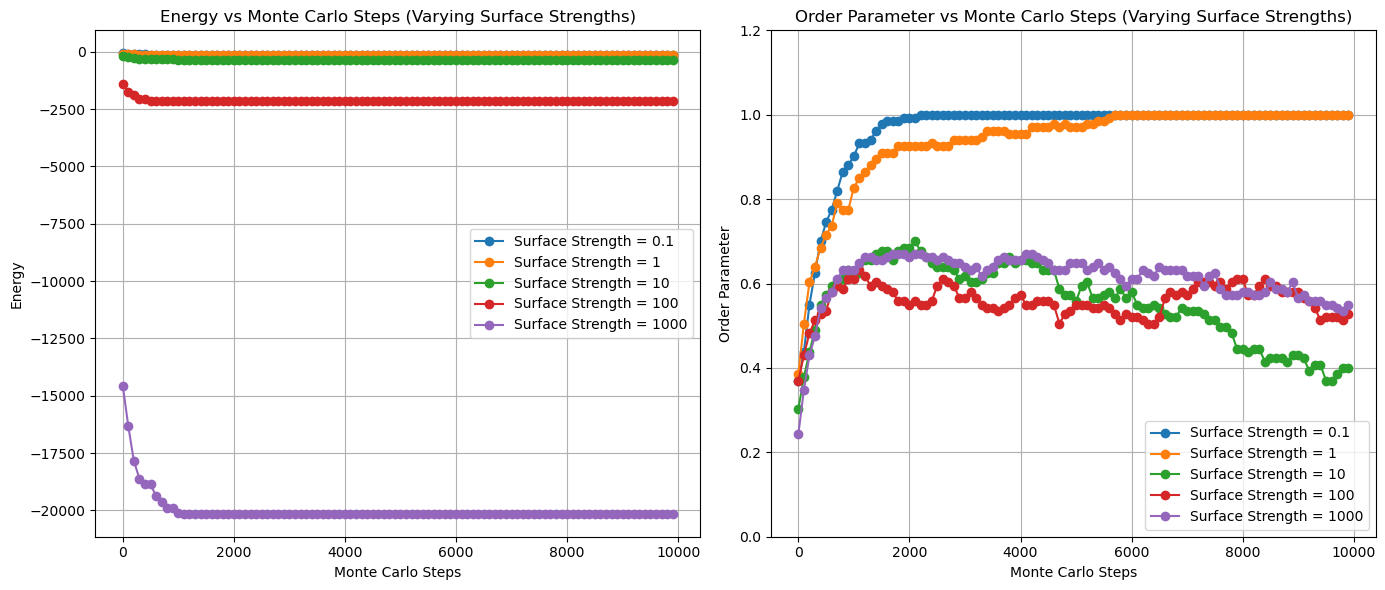

Text(0, 0.5, 'Order Parameter')

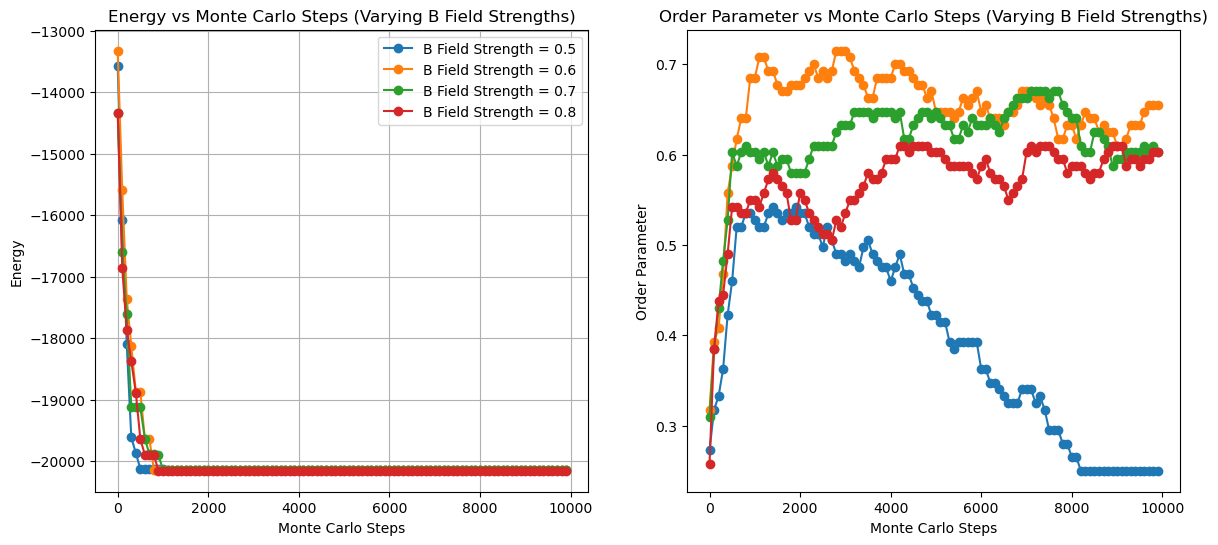

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import circmean

# Constants
N = 10  # Size of the grid (N x N)
epsilon = 1.0  # Interaction strength
k_B = 1.38e-23
steps = 10000  # Number of Monte Carlo steps
reduced_temp = 0.1  # Reduced temperature
temperature = reduced_temp * epsilon / k_B
mu = 1.0  # Magnetic moment

B_field_direction = np.pi / 4  # Field direction (18 degrees)
B_field_vector = np.array([np.cos(B_field_direction), np.sin(B_field_direction)])

# Possible director angles in radians
angles = np.deg2rad(np.arange(0, 180, 45))

# Define shifts for periodic boundary conditions
shifts = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Surface alignment direction
tangential_direction = 0 *np.pi / 2  # 90 degrees

# Function Definitions (Same as before with surface energy)

def calculate_energy_contributions(directors):
    cos_theta = np.cos(directors)
    sin_theta = np.sin(directors)
    energy = np.zeros_like(directors)

    for dx, dy in shifts:
        cos_shifted = np.roll(cos_theta, shift=(dx, dy), axis=(0, 1))
        sin_shifted = np.roll(sin_theta, shift=(dx, dy), axis=(0, 1))
        cos_diff = cos_theta * cos_shifted + sin_theta * sin_shifted
        energy += -epsilon * (cos_diff**2 - 1/3)
        energy_eps = energy / epsilon
    
    return energy_eps

def calculate_field_energy(directors, B_field_vector):
    cos_theta = np.cos(directors)
    sin_theta = np.sin(directors)
    B_cos = B_field_vector[0]
    B_sin = B_field_vector[1]
    field_energy = -mu * (cos_theta * B_cos + sin_theta * B_sin)
    field_energy_mu = field_energy / mu
    return field_energy_mu

def calculate_surface_energy(directors, surface_strength, tangential_direction):
    energy = np.zeros_like(directors)
    # Apply tangential alignment on the borders
    tangential_energy = surface_strength * np.cos(directors - tangential_direction)**2
    energy[0, :] += tangential_energy[0, :]  # Top row
    energy[-1, :] += tangential_energy[-1, :]  # Bottom row
    energy[:, 0] += tangential_energy[:, 0]  # Left column
    energy[:, -1] += tangential_energy[:, -1]  # Right column
    energy_surface = -energy # / surface_strength
    return energy_surface

def calculate_total_energy(directors, B_field_vector, surface_strength):
    interaction_energy_eps = calculate_energy_contributions(directors)
    field_energy_mu = calculate_field_energy(directors, B_field_vector)
    surface_energy_surface = calculate_surface_energy(directors, surface_strength, tangential_direction)
    total_energy = interaction_energy_eps + field_energy_mu + surface_energy_surface
    return np.sum(total_energy) / 2  # Each interaction is counted twice, so divide by 2

def monte_carlo_step(directors, reduced_temp, B_field_vector, surface_strength):
    i, j = np.random.randint(N), np.random.randint(N)  # Randomly select a site
    
    # Calculate current energy contributions
    current_energy = calculate_total_energy(directors, B_field_vector, surface_strength)
    
    # Flip orientation (rotate by ±18 degrees)
    current_angle = directors[i, j]
    new_angle = current_angle + np.pi / 4 * np.random.choice([-1, 1])
    new_angle = new_angle % np.pi  # Ensure angle is within [0, π)
    
    new_directors = directors.copy()
    new_directors[i, j] = new_angle
    
    # Calculate new energy contributions
    new_energy = calculate_total_energy(new_directors, B_field_vector, surface_strength)
    
    # Metropolis criterion
    delta_E = new_energy - current_energy
    if delta_E <= 0 or np.random.rand() < np.exp(-delta_E / reduced_temp):
        directors[i, j] = new_angle  # Accept the change
    
    return directors

def calculate_order_parameter(directors, B_field_direction):
    average_angle = circmean(directors.flatten(), high=np.pi)
    aligned_directors = (directors - B_field_direction + np.pi) % np.pi
    cos_theta = np.cos(aligned_directors)
    order_parameter = np.mean((3 * cos_theta**2 - 1) / 2)
    return order_parameter

def run_simulation(steps, reduced_temp, initial_directors, B_field_vector, surface_strength):
    directors = initial_directors.copy()  # Initialize with the same random orientations
    energies = []
    order_parameters = []

    for step in range(steps):
        directors = monte_carlo_step(directors, reduced_temp, B_field_vector, surface_strength)
        if (step + 1) % 100 == 0:
            energies.append(calculate_total_energy(directors, B_field_vector, surface_strength))
            order_parameters.append(calculate_order_parameter(directors, B_field_direction))
    
    final_order_parameter = calculate_order_parameter(directors, B_field_direction)
    return directors, energies, order_parameters, final_order_parameter

# Varying Surface Strengths at Constant Magnetic Field
surface_strengths = [0.1, 1, 10, 100, 1000]
B_field_strength = 0.5  # Fixed field strength
B_field_vector = B_field_strength * np.array([np.cos(B_field_direction), np.sin(B_field_direction)])
initial_directors = np.random.choice(angles, size=(N, N))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

for surface_strength in surface_strengths:
    directors_final, energies, order_parameters, final_order_parameter = run_simulation(steps, reduced_temp, initial_directors, B_field_vector, surface_strength)
    plt.plot(np.arange(len(energies)) * 100, energies, marker='o', linestyle='-', label=f'Surface Strength = {surface_strength}')

plt.title('Energy vs Monte Carlo Steps (Varying Surface Strengths)')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Energy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)

for surface_strength in surface_strengths:
    directors_final, energies, order_parameters, final_order_parameter = run_simulation(steps, reduced_temp, initial_directors, B_field_vector, surface_strength)
    plt.plot(np.arange(len(order_parameters)) * 100, order_parameters, marker='o', linestyle='-', label=f'Surface Strength = {surface_strength}')

plt.title('Order Parameter vs Monte Carlo Steps (Varying Surface Strengths)')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Order Parameter')
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Varying Magnetic Fields at Constant Surface Strength
B_field_strengths = [0.5, 0.6, 0.7, 0.8]
surface_strength = 1000  # Fixed surface strength
initial_directors = np.random.choice(angles, size=(N, N))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

for B_strength in B_field_strengths:
    B_field_vector = B_strength * np.array([np.cos(B_field_direction), np.sin(B_field_direction)])
    directors_final, energies, order_parameters, final_order_parameter = run_simulation(steps, reduced_temp, initial_directors, B_field_vector, surface_strength)
    plt.plot(np.arange(len(energies)) * 100, energies, marker='o', linestyle='-', label=f'B Field Strength = {B_strength}')

plt.title('Energy vs Monte Carlo Steps (Varying B Field Strengths)')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Energy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)

for B_strength in B_field_strengths:
    B_field_vector = B_strength * np.array([np.cos(B_field_direction), np.sin(B_field_direction)])
    directors_final, energies, order_parameters, final_order_parameter = run_simulation(steps, reduced_temp, initial_directors, B_field_vector, surface_strength)
    plt.plot(np.arange(len(order_parameters)) * 100, order_parameters, marker='o', linestyle='-', label=f'B Field Strength = {B_strength}')

plt.title('Order Parameter vs Monte Carlo Steps (Varying B Field Strengths)')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Order Parameter')
